In [1]:
import helper_functions as hlp
from pytorch_model_and_dataloader import *
from sklearn.model_selection import train_test_split
import numpy as np
import spacy
import pickle
import os
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path = '../../data/hw1/aclImdb/train'
test_path = '../../data/hw1/aclImdb/test'
processed_path = './processed'

In [4]:
x_train, y_train, x_test, y_test = hlp.load_data(train_path, test_path, return_ratings=True)

In [5]:
x_train = x_train[:200] + x_train[-200:];
y_train = y_train[:200] + y_train[-200:]
x_test = x_test[:100] + x_test[-100:]
y_test = y_test[:100] + y_test[-100:]

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
...     x_train, y_train, test_size=0.2)

In [27]:
def plot_acc(train_acc, val_acc, filename):
    assert(len(train_acc) == len(val_acc));
    
    f = plt.figure()
    plt.plot(train_acc, label='train');
    plt.plot(val_acc, label = 'val');
    plt.title(filename);
    plt.legend()
    
    f.savefig(filename + ".pdf", bbox_inches='tight')
    plt.show() 

In [18]:
def train_and_evaluate(token_scheme, n, all_until_n, max_vocab_size, emb_dim, optim, lr_schedule):

    file_name = '_'.join([token_scheme, str(n), str(all_until_n), 
                         str(max_vocab_size), str(emb_dim), optim, lr_schedule]);
    print(file_name)
    
    learning_rate = 0.01
    num_epochs = 10 # number epoch to train
    BATCH_SIZE = 32

    tokenizer = spacy.load(token_scheme)

    val_tokenized_x, val_tokenized_y = hlp.load_tokenized_data(processed_path, 'val', 
                                                               x_val, y_val, tokenizer, n, token_scheme, all_until_n)
    train_tokenized_x, train_tokenized_y = hlp.load_tokenized_data(processed_path, 'train', 
                                                               x_train, y_train, tokenizer, n, token_scheme, all_until_n)
    test_tokenized_x, test_tokenized_y = hlp.load_tokenized_data(processed_path, 'test', 
                                                               x_test, y_test, tokenizer, n, token_scheme, all_until_n)
    all_train_tokens = hlp.load_tokenized_data(processed_path, 'tokens', 
                                                               x_train, y_train, tokenizer, n, token_scheme, all_until_n)

    token2id, id2token = hlp.build_vocab(all_train_tokens, max_vocab_size)

    train_data_indices = hlp.token2index_dataset(train_tokenized_x, token2id)
    val_data_indices = hlp.token2index_dataset(val_tokenized_x, token2id)
    test_data_indices = hlp.token2index_dataset(test_tokenized_x, token2id)

    train_dataset = NewsGroupDataset(train_data_indices, train_tokenized_y)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_tokenized_y)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_tokenized_y)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)


    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    if(optim == 'adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_acc_array = [];
    val_acc_array = [];
    for epoch in range(num_epochs):
        if(lr_schedule == 'linear_annealing'):
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 1 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_array.append(val_acc);
                train_acc_array.append(test_model(train_loader, model))
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                
    plot_acc(train_acc_array, val_acc_array, file_name)
    
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)

In [22]:
token_scheme_array = ['en_core_web_sm'];
n_array = [1];
all_until_n_array = [True]
max_vocab_size_array = [10000]
emb_dim_array = [10, 100]
optim_array = ['sgd']
lr_schedule_array = ['constant']

en_core_web_sm_1_True_10000_10_sgd_constant
Epoch: [1/10], Step: [2/5], Validation Acc: 0.0
Epoch: [1/10], Step: [3/5], Validation Acc: 0.0
Epoch: [1/10], Step: [4/5], Validation Acc: 2.5
Epoch: [1/10], Step: [5/5], Validation Acc: 2.5
Epoch: [2/10], Step: [2/5], Validation Acc: 5.0
Epoch: [2/10], Step: [3/5], Validation Acc: 5.0
Epoch: [2/10], Step: [4/5], Validation Acc: 5.0
Epoch: [2/10], Step: [5/5], Validation Acc: 10.0
Epoch: [3/10], Step: [2/5], Validation Acc: 20.0
Epoch: [3/10], Step: [3/5], Validation Acc: 27.5
Epoch: [3/10], Step: [4/5], Validation Acc: 30.0
Epoch: [3/10], Step: [5/5], Validation Acc: 32.5
Epoch: [4/10], Step: [2/5], Validation Acc: 45.0
Epoch: [4/10], Step: [3/5], Validation Acc: 55.0
Epoch: [4/10], Step: [4/5], Validation Acc: 60.0
Epoch: [4/10], Step: [5/5], Validation Acc: 67.5
Epoch: [5/10], Step: [2/5], Validation Acc: 80.0
Epoch: [5/10], Step: [3/5], Validation Acc: 82.5
Epoch: [5/10], Step: [4/5], Validation Acc: 85.0
Epoch: [5/10], Step: [5/5], Vali

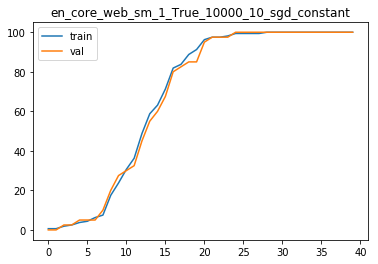

After training for 10 epochs
Train Acc 100.0
Val Acc 100.0
Test Acc 100.0
en_core_web_sm_1_True_10000_100_sgd_constant
Epoch: [1/10], Step: [2/5], Validation Acc: 15.0
Epoch: [1/10], Step: [3/5], Validation Acc: 20.0
Epoch: [1/10], Step: [4/5], Validation Acc: 27.5
Epoch: [1/10], Step: [5/5], Validation Acc: 37.5
Epoch: [2/10], Step: [2/5], Validation Acc: 52.5
Epoch: [2/10], Step: [3/5], Validation Acc: 57.5
Epoch: [2/10], Step: [4/5], Validation Acc: 70.0
Epoch: [2/10], Step: [5/5], Validation Acc: 80.0
Epoch: [3/10], Step: [2/5], Validation Acc: 90.0
Epoch: [3/10], Step: [3/5], Validation Acc: 90.0
Epoch: [3/10], Step: [4/5], Validation Acc: 92.5
Epoch: [3/10], Step: [5/5], Validation Acc: 92.5
Epoch: [4/10], Step: [2/5], Validation Acc: 97.5
Epoch: [4/10], Step: [3/5], Validation Acc: 100.0
Epoch: [4/10], Step: [4/5], Validation Acc: 100.0
Epoch: [4/10], Step: [5/5], Validation Acc: 100.0
Epoch: [5/10], Step: [2/5], Validation Acc: 100.0
Epoch: [5/10], Step: [3/5], Validation Acc: 

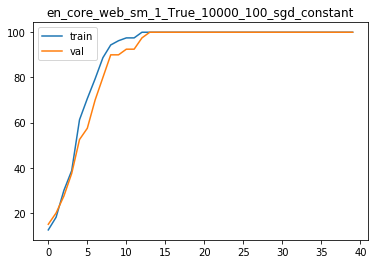

After training for 10 epochs
Train Acc 100.0
Val Acc 100.0
Test Acc 100.0


In [28]:
with open('somefile.txt', 'a') as thefile:
    for token_scheme in token_scheme_array:
        for n in n_array:
            for all_until_n in all_until_n_array:
                for max_vocab_size in max_vocab_size_array:
                    for emb_dim in emb_dim_array:
                        for optim in optim_array:
                            for lr_schedule in lr_schedule_array:

                                train_acc, val_acc, test_acc = train_and_evaluate(token_scheme, n, all_until_n, 
                                                                                  max_vocab_size, emb_dim, optim, 
                                                                                  lr_schedule)
                                thefile.write(','.join([token_scheme, str(n), str(all_until_n), str(max_vocab_size), 
                                                 str(emb_dim), optim, lr_schedule, str(train_acc),
                                                       str(val_acc), str(test_acc)])+'\n')